In [1]:
import tensorflow as tf
import pickle
import sys
import matplotlib.pyplot as plt1 
import numpy as np
from IPython.display import Audio, display
import time
from sklearn.model_selection import train_test_split
import random

/Users/dweepa/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def done():
    framerate = 44100
    duration=0.6
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    display(Audio(data, rate=framerate, autoplay=True))

In [3]:
full = pickle.load(open('../../Data/full', 'rb'))
dbfile = open('../../Data/test_perts', 'rb')
test_pert = pickle.load(dbfile)
dbfile = open('../../Data/train_perts', 'rb')
train_pert = pickle.load(dbfile)
dbfile.close()

In [4]:
all_pert = np.concatenate((train_pert, test_pert))

In [7]:
s = siamese("cos", "net")

In [8]:
run_network(model_name, embedding_name, s, epoch, X, test, full)

NameError: name 'run_network' is not defined

In [11]:
X = pickle.load(open('../../Data/X_train_triplet', 'rb'))
test = pickle.load(open('../../Data/X_test_triplet', 'rb'))

In [12]:
# index = np.random.choice(X.shape[1],84, replace=False)  
index = np.arange(42)
x_test_anch = X[0][index]
x_test_pos = X[1][index]
x_test_neg = X[2][index]

def Diff(li1, li2):
    li_dif = [i for i in li1 if i not in li1 or i not in li2]
    return li_dif

index2 = Diff([i for i in range(X.shape[1])], index)

x_train_anch = X[0][index2]
x_train_pos = X[1][index2]
x_train_neg = X[2][index2]

X = [x_train_anch, x_train_pos, x_train_neg]
test = [x_test_anch, x_test_pos, x_test_neg]

len(X[0]),len(test[0])

(378, 42)

In [13]:
class siamese:

    # Create model
    def __init__(self, loss='cos', network='net'):
        tf.reset_default_graph()
        self.x1 = tf.placeholder(tf.float32, [None, 978])
        self.x2 = tf.placeholder(tf.float32, [None, 978])
        self.x3 = tf.placeholder(tf.float32, [None, 978])
        
        if network=='net':
            self.network = self.normalnet
        if network=='densenet':
            self.network = self.densenet

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)
            scope.reuse_variables()
            self.o3 = self.network(self.x3)

        if loss=='cos':
            self.loss = self.loss_with_cosine()
        if loss=='euc':
            self.loss = self.loss_with_euclid()
            
    def normalnet(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        d1 = tf.nn.dropout(ac1,0.5)
        
        fc2 = self.fc_layer(d1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        d2 = tf.nn.dropout(ac2,0.5)
        
        fc3 = self.fc_layer(ac2, 1024, "fc3")
        ac3 = tf.nn.relu(fc3)
        d3 = tf.nn.dropout(ac3,0.5)
        
        fc4 = self.fc_layer(d2, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def dense_network(self, x):
        weights = []
        
        fc1 = self.fc_layer(x, 400, "fc1")
        ac1 = tf.nn.relu(fc1)
        op_concat1 = tf.concat([x, ac1], axis=1)
        
        fc2 = self.fc_layer(op_concat1, 400, "fc2")
        ac2 = tf.nn.relu(fc2)
        op_concat2 = tf.concat([op_concat1, ac2], axis=1)
        
        fc3 = self.fc_layer(op_concat2, 400, "fc3")
        ac3 = tf.nn.relu(fc3)
        op_concat3 = tf.concat([op_concat2, ac3], axis=1)
        
        fc4 = self.fc_layer(op_concat3, 32, "fc4")
        
        fc4 = tf.nn.l2_normalize(fc4, axis=1)
        return fc4

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_euclid(self):  
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.sqrt(tf.reduce_sum(eucd2, axis=1))
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.pow(tf.subtract(self.o1, self.o3), 2)
        eucd3 = tf.sqrt(tf.reduce_sum(eucd3, axis=1))
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3
    
    def loss_with_cosine(self):  
        eucd2 = tf.multiply(self.o1, self.o2)
        eucd2 = 1-tf.pow(tf.reduce_sum(eucd2, axis=1), 2)
        eucd2_mean = tf.reduce_mean(eucd2, axis=0)
        
        eucd3 = tf.multiply(self.o1, self.o3)
        eucd3 = 1-tf.pow(tf.reduce_sum(eucd3, axis=1), 2)
        eucd3_mean = tf.reduce_mean(eucd3, axis=0)
        
        return eucd2_mean, eucd3_mean, eucd2, eucd3

In [14]:
def run_network(s, epochs,X=X, test=test):    
    optim_pos = tf.train.AdamOptimizer(0.005).minimize(s.loss[0])
    optim_neg = tf.train.AdamOptimizer(0.005).minimize(-s.loss[1])
    with tf.Session() as session:  
        tf.initialize_all_variables().run()
        print("Initialized")

        feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]}

        p_loss = []
        n_loss = []
        train_acc_l = []
        test_acc_l = []
        print("Epoch\t\t+ Dist\t- Dist\t\tTrain\tTest")
        for a in range(epochs):        
            p_loss.append([])
            n_loss.append([])
            for b in range(len(X[0])):
                sys.stdout.write('\rEpoch %d:\t%d/%d' % (a, b+1, len(X[0])))
                feed_dict = {s.x1:X[0][b:b+1], s.x2:X[1][b:b+1], s.x3:X[2][b:b+1]}
                _, _, l = session.run([optim_pos, optim_neg, s.loss], feed_dict=feed_dict)
                p_loss[-1].append(l[0])
                n_loss[-1].append(l[1])
            p_loss[-1] = sum(p_loss[-1])/len(p_loss[-1])
            n_loss[-1] = sum(n_loss[-1])/len(n_loss[-1]) 
            
            trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
            pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
            
            train_acc = 100*(np.sum(trained[0][2]<=0.5)+np.sum(trained[0][3]>0.5))/len(X[0])/2
            test_acc = 100*(np.sum(pred[0][2]<=0.5)+np.sum(pred[0][3]>0.5))/len(test[0])/2 
            
            train_acc_l.append(train_acc)
            test_acc_l.append(test_acc)
            
#             print(" ", p_loss[-1], n_loss[-1], train_acc, test_acc)
            print(f"\rEpoch {a}:\t{'{0:.4f}'.format(p_loss[-1])}\t{'{0:.4f}'.format(n_loss[-1])}\t\t{'{0:.2f}'.format(train_acc)}\t{'{0:.2f}'.format(test_acc)}")

        embeddings = session.run([s.o1, s.o2, s.o3], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        trained = session.run([s.loss], feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]})
        pred = session.run([s.loss], feed_dict={s.x1:test[0], s.x2:test[1], s.x3:test[2]})
        
        return embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l

In [15]:
def graph(p_loss, n_loss, train_acc_l=None, test_acc_l=None):
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(epochs), p_loss, label='positive')
    plt.plot(np.arange(epochs), n_loss, label='negative')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()
    
    if train_acc_l!=None and test_acc_l!=None:
        plt.figure(figsize=(20, 6))
        plt.plot(np.arange(epochs), train_acc_l, label='train')
        plt.plot(np.arange(epochs), test_acc_l, label='test')
        plt.legend()
        plt.title("Accuracy over epochs")
        plt.show()

In [16]:
epochs = 20

### Euclidean

In [9]:
s = siamese("euc", "net")

In [10]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.3393	0.6532		56.88	53.57
Epoch 1:	0.6600	0.9514		63.23	64.29
Epoch 2:	0.6176	1.0031		69.58	60.71
Epoch 3:	0.6058	1.1867		69.84	57.14
Epoch 4:	0.5156	1.3222		74.47	58.33
Epoch 5:	0.4808	1.3149		77.65	67.86
Epoch 6:	0.4647	1.4445		80.42	65.48
Epoch 7:	0.4348	1.5158		83.73	63.10
Epoch 8:	0.3673	1.6146		84.39	60.71
Epoch 9:	0.3110	1.5901		82.14	61.90
Epoch 10:	0.2118	1.6446		74.60	51.19
Epoch 11:	0.1292	1.6421		76.59	50.00
Epoch 12:	0.1524	1.6135		86.77	60.71
Epoch 13:	0.2432	1.6400		90.61	54.76
Epoch 14:	0.1220	1.6813		91.27	61.90
Epoch 15:	0.0943	1.7232		88.89	53.57
Epoch 16:	0.1595	1.6862		91.40	59.52
Epoch 17:	0.1025	1.7530		92.46	57.14
Epoch 18:	0.0898	1.7361		89.29	54.76
Epoch 19:	0.1109	1.7244		90.34	51.19


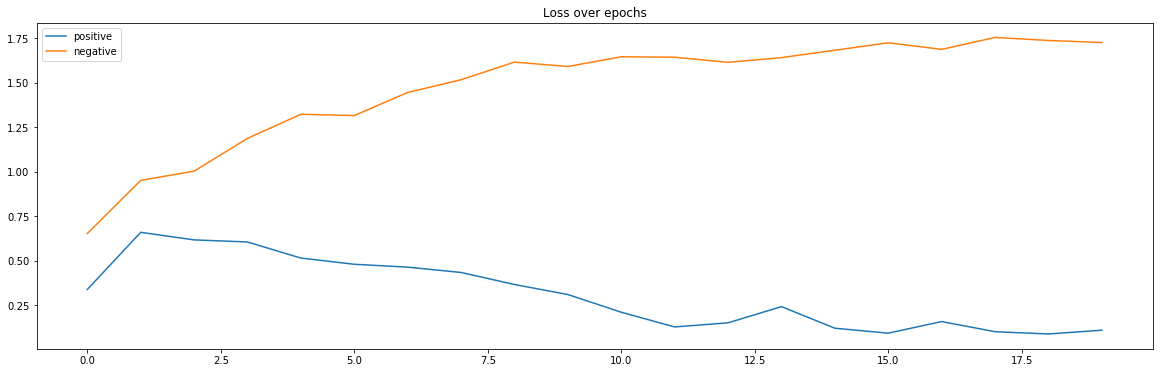

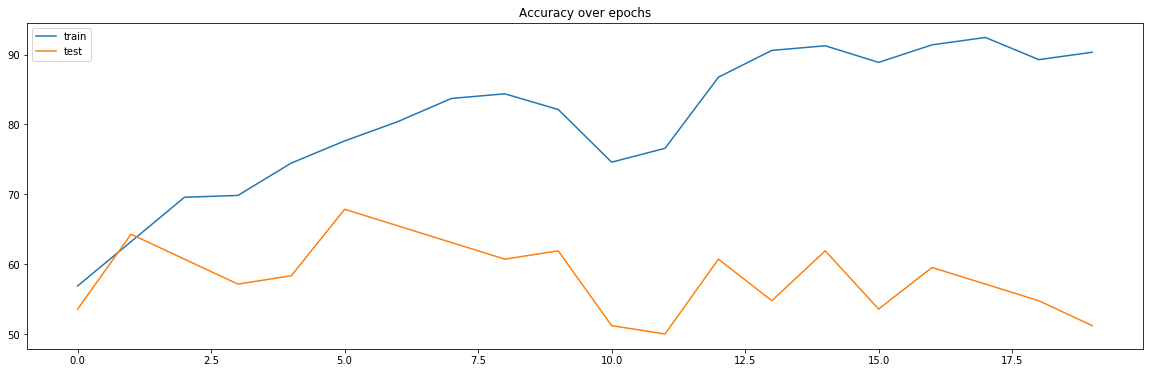

In [11]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [12]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/len(X[0])/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/len(test[0])/2)

Training Accuracy 0.9034391534391535
Testing Accuracy 0.5119047619047619


### Cosine

In [17]:
s = siamese("cos", "net")

In [18]:
embeddings, trained, pred, p_loss, n_loss, train_acc_l, test_acc_l = run_network(s, epochs)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Epoch		+ Dist	- Dist		Train	Test
Epoch 0:	0.1725	0.3371		61.51	59.52
Epoch 1:	226/378

KeyboardInterrupt: 

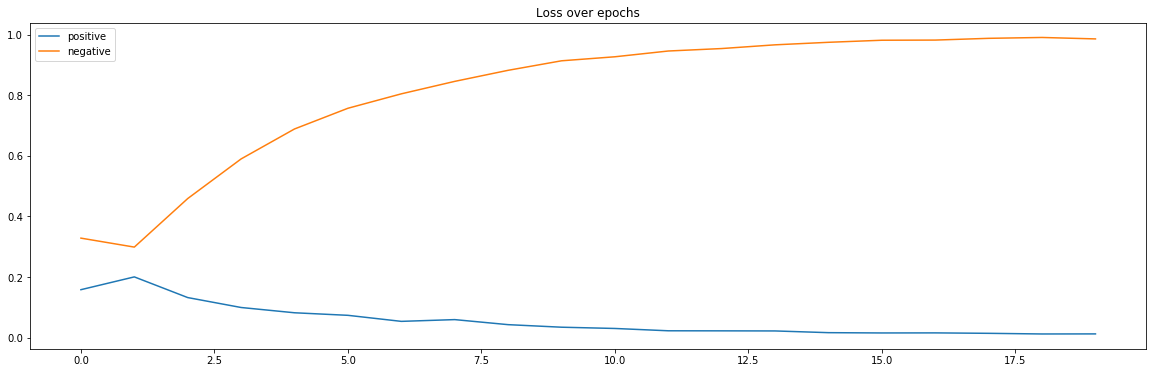

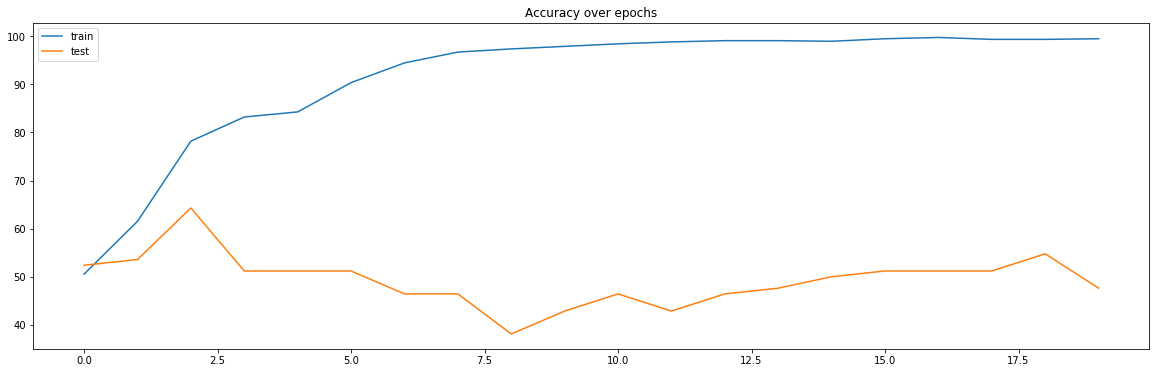

In [15]:
graph(p_loss, n_loss, train_acc_l, test_acc_l)

In [16]:
p = np.sum(trained[0][2]<=0.5)
n = np.sum(trained[0][3]>0.5)
print("Training Accuracy", (p+n)/len(X[0])/2)

p = np.sum(pred[0][2]<=0.5)
n = np.sum(pred[0][3]>0.5)
print("Testing Accuracy", (p+n)/len(test[0])/2)

Training Accuracy 0.9947089947089947
Testing Accuracy 0.47619047619047616


In [17]:
i = 3
while i:
    i-=1
    done()
    time.sleep(1.2)

/Users/dweepa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [18]:
train_pert = pickle.load(open('../Data/train_perts', 'rb'))
test_pert = np.asarray(pickle.load(open('../Data/test_perts', 'rb')))

In [19]:
all_pert = np.concatenate((train_pert,test_pert))
all_pert

array(['BRD-K42352790', 'BRD-K35189033', 'BRD-K45158365', ...,
       'BRDN0001055121', 'BRDN0001055134', 'BRDN0001055244'], dtype=object)

In [35]:
len(X[0])

378

In [2]:
# Import custom modules
from network import *
from data import *

import tensorflow as tf
import pickle
import sys
import matplotlib.pyplot as plt1 
import numpy as np
from IPython.display import Audio, display
import time
from sklearn.model_selection import train_test_split
import random

dbfile = open('../Data/full', 'rb')    
data = pickle.load(dbfile)
dbfile = open('../Data/location_pert', 'rb')    
location_pert = pickle.load(dbfile)
dbfile = open('../Data/pert2profiles', 'rb')    
pert2profiles = pickle.load(dbfile)
dbfile = open('../Data/test_perts', 'rb')    
test_pert = pickle.load(dbfile)
dbfile = open('../Data/train_perts', 'rb')    
train_pert = pickle.load(dbfile)
dbfile = open('../Data/X_test_triplet', 'rb')
X_test = pickle.load(dbfile)
dbfile = open('../Data/X_train_triplet', 'rb')
X_train = pickle.load(dbfile)
dbfile.close()

generate_data(data,train_pert[0:100],100) 

ValueError: Lengths must match to compare